In [77]:
# %matplotlib widget
# Load packages and settings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns



import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf

import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)
from matplotlib import cm # Colormaps
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
import matplotlib.dates as mdates
locale.setlocale(locale.LC_TIME,"Danish")
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.spines['top'].set_visible(False) 

import os
# import csv
import math

# from datetime import date
import datetime


saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

saveFigures is set to: True
Done loading packages


In [78]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 

In [79]:
# Get case data from Gennembruds_DB
latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir

df = pd.read_csv(latestdir+'/Gennembruds_DB/04_bekræftede_tilfælde_pr_vaccinationsstatus_pr_aldersgrp_pr_uge.csv',encoding='latin1',delimiter=';')
dfAdm = pd.read_csv(latestdir+'/Gennembruds_DB/06_nyindlagte_pr_vaccinationsstatus_pr_aldersgrp_pr_uge.csv',encoding='latin1',delimiter=';')


df['Cases'] = df['Bekræftede tilfælde']
dfAdm['Adm'] = dfAdm['Antal nyindlagte']

In [80]:
# Start by getting the most recent data

for k in range(0,7):
    dayToCheck = np.datetime64('today')-np.timedelta64(k,'D')
    thisWeekDay = (dayToCheck).astype(datetime.datetime).isoweekday()    
    if (thisWeekDay == 2):
        tuePath = 'SSI_data_'+str(dayToCheck)
        if (os.path.exists(path_data + tuePath) == False):
            print('No data for most recent tuesday... If after 14:00, download new data')
            tuePath = 'SSI_data_'+str(dayToCheck-np.timedelta64(7,'D')) 

print(f'Path to latest Tuesday was {tuePath}')

dirPath = path_data + tuePath + '/'

dfRecent = pd.read_csv(dirPath+'gennembrudsinfektioner_table1.csv',delimiter=';')
df2_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_cases.csv',delimiter=';')
df3_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_cases.csv',delimiter=';')
df3_A = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_alle.csv',delimiter=';')

df2_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_tests.csv',delimiter=';')
df3_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_tests.csv',delimiter=';')
# df3_C.iloc[:,1:] = pd.to_numeric(df3_C.iloc[:,1:].str.replace(',','.'))
for col in df3_C.columns[1:]:
    df3_C[col] = pd.to_numeric(df3_C[col].str.replace(',','.'))
    df3_A[col] = pd.to_numeric(df3_A[col].str.replace(',','.'))
    df3_T[col] = pd.to_numeric(df3_T[col].str.replace(',','.'))


No data for most recent tuesday... If after 14:00, download new data
Path to latest Tuesday was SSI_data_2022-03-22


In [81]:
posWeekNames = np.unique([x[:11] for x in df2_C.columns[1:]])
weekOrder = np.argsort([x[-4:] + x[4:6] for x in posWeekNames])
allWeekNames = posWeekNames[weekOrder]

        
sNone = 'Ingen vaccination'        
sOne = 'Første vaccination'  
sTwo = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'   
sReva = 'Fuld effekt efter revaccination'

curDTs= [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in allWeekNames]


In [82]:
def getTimeSeries(thisdf=df2_C,curStatus='Ingen vaccination',curAge='Alle',weekNames=allWeekNames):
    # If curAge is just a string, return the given array
    if (type(curAge)==str):
        agedf = thisdf[thisdf.Aldersgruppe==curAge]
        allVals = []
        for curWeek in weekNames:
            toAdd = agedf[curWeek+'_'+curStatus].values[0]
            allVals.append(toAdd)
        allVals = np.array(allVals)
        
        return allVals 
        
    else:
        # If curAge is not a string, it is assumed to be a list of strings
        totCount = []
        for thisAge in curAge:
            agedf = thisdf[thisdf.Aldersgruppe==thisAge]
            allVals = []
            for curWeek in weekNames:
                toAdd = agedf[curWeek+'_'+curStatus].values[0]
                allVals.append(toAdd)
            allVals = np.array(allVals)
            if len(totCount) == 0:
                totCount = allVals 
            else:
                totCount = totCount + allVals
        return totCount

def getTimeSeriesAll(thisdf=df2_C,curAge='Alle',weekNames=allWeekNames):
    return getTimeSeries(thisdf,sNone,curAge,weekNames)+getTimeSeries(thisdf,sOne,curAge,weekNames)+getTimeSeries(thisdf,sTwo,curAge,weekNames)

getTimeSeriesAll()

array([ 34232,  47638,  73205,  76377, 119337, 126663, 171548, 266972,
       280599, 279819, 297396, 225842, 143489, 104605,  75969,  48095],
      dtype=int64)

In [83]:

df['Dato'] = [np.datetime64(datetime.datetime.strptime(d+'-1', "%G-W%V-%u")) for d in df.Uge]
dfAdm['Dato'] = [np.datetime64(datetime.datetime.strptime(d+'-1', "%G-W%V-%u")) for d in dfAdm.Uge]

In [84]:
# Plot cases
curAge = '20-39'
curAge = '16-19'
curStatus = '2. stik'

curdf = df[(df.Aldersgruppe == curAge) & (df.Vaccinationsstatus == curStatus)]
# curdf.tail()

In [85]:
getTimeSeries(df2_C,sFull)

array([ 17605,  25673,  46511,  52477,  71042,  67496,  72605, 104003,
        97397,  82376,  70892,  41056,  21508,  14132,   9346,   4838],
      dtype=int64)

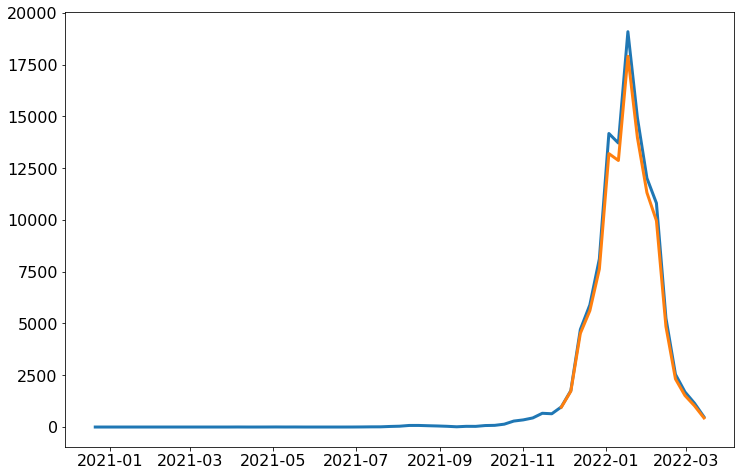

In [86]:
fig,ax = plt.subplots() 

ax.plot(curdf.Dato,curdf.Cases)
# curCases = getTimeSeries(df2_C,sFull,['20-29','30-39'])
curCases = getTimeSeries(df2_C,sFull,curAge)
ax.plot(curDTs,curCases)

In [87]:
curdf.tail()

,Uge,Aldersgruppe,Vaccinationsstatus,Bekræftede tilfælde,sort_Var,Befolkningstørrelse,Bekræftede tilfælde pr. 100.000,Cases,Dato
1690,2022-W07,16-19,2. stik,5258,2,129990,"4044,93",5258,2022-02-14
1718,2022-W08,16-19,2. stik,2544,2,127986,"1987,72",2544,2022-02-21
1746,2022-W09,16-19,2. stik,1695,2,127121,"1333,38",1695,2022-02-28
1774,2022-W10,16-19,2. stik,1152,2,126501,"910,66",1152,2022-03-07
1802,2022-W11,16-19,2. stik,487,2,125752,"387,27",487,2022-03-14


In [88]:
# print(df.Aldersgruppe.unique())
# df3_A

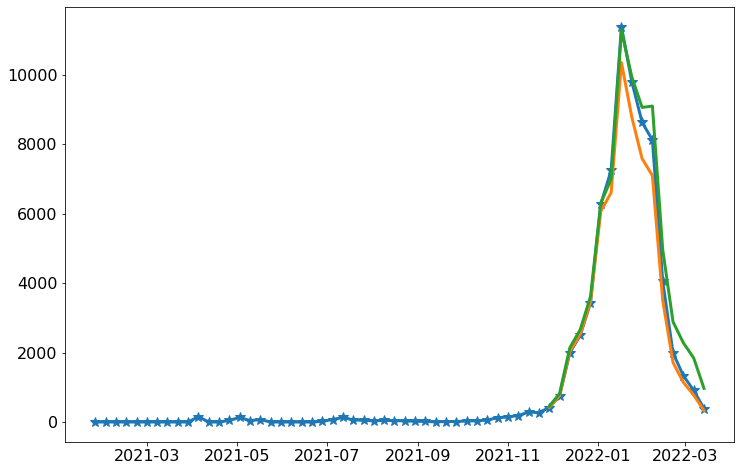

In [91]:
fig,ax = plt.subplots() 

ax.plot(curdf.Dato,100000*curdf.Cases/curdf['Befolkningstørrelse'],'*-')
curCases = getTimeSeries(df3_A,sFull,curAge)
ax.plot(curDTs,curCases)
curCases = getTimeSeries(df3_C,sFull,curAge)
ax.plot(curDTs,curCases)

In [149]:
100000*df2_C.iloc[:,1:6]/df3_C.iloc[:,1:6]
100000*df2_C.iloc[:,1:6]/df3_A.iloc[:,1:6]
100000*df2_T.iloc[:,1:6]/df3_T.iloc[:,1:6]

,Uge 11-2022_Ingen vaccination,Uge 11-2022_Første vaccination,Uge 11-2022_Anden vaccination,Uge 11-2022_Fuld effekt efter primært forløb,Uge 11-2022_Fuld effekt efter revaccination
0,3.664997e+05,5011.135857,1.193307e+04,1.177808e+04,NaN
1,1.802080e+05,33178.446238,1.521960e+05,1.511398e+05,NaN
2,5.191757e+04,6336.793852,2.161677e+05,2.151064e+05,7.489963e+02
3,2.864368e+04,3503.896575,2.429166e+05,1.481689e+05,9.460852e+04
4,1.337447e+05,15673.736744,6.366280e+05,2.154694e+05,4.206448e+05
5,1.134344e+05,12565.914956,5.891444e+05,2.136016e+05,3.751451e+05
6,6.885177e+04,5632.967685,6.629639e+05,1.038496e+05,5.589395e+05
7,4.876924e+04,3253.990622,7.550226e+05,5.831731e+04,6.965895e+05
8,1.527022e+04,962.996353,3.359354e+05,1.559189e+04,3.203213e+05
9,1.082118e+04,651.000651,3.117630e+05,9.426941e+03,3.023137e+05


In [113]:
print(df2_C.Aldersgruppe.values)

['0-5' '6-11' '12-15' '16-19' '20-29' '30-39' '40-49' '50-59' '60-64'
 '65-69' '70-79' '80+' '12+' 'Alle']


In [148]:
# curdf.tail()
df[df.Vaccinationsstatus == 'Uvaccinerede'].iloc[-6:]

# df[df.Vaccinationsstatus == 'Uvaccinerede'].iloc[-6:]['Befolkningstørrelse'].sum()
# df[df.Vaccinationsstatus == 'Uvaccinerede'].iloc[-6:]['Befolkningstørrelse'].sum()
df[df.Vaccinationsstatus == 'Uvaccinerede'].iloc[-6:]['Befolkningstørrelse'].sum()
# df[df.Vaccinationsstatus == '1. stik'].iloc[-6:]['Befolkningstørrelse'].sum()

496359

In [142]:
df2_C

,Aldersgruppe,Uge 11-2022_Ingen vaccination,Uge 11-2022_Første vaccination,Uge 11-2022_Anden vaccination,Uge 11-2022_Fuld effekt efter primært forløb,Uge 11-2022_Fuld effekt efter revaccination,Uge 10-2022_Ingen vaccination,Uge 10-2022_Første vaccination,Uge 10-2022_Anden vaccination,Uge 10-2022_Fuld effekt efter primært forløb,...,Uge 49-2021_Ingen vaccination,Uge 49-2021_Første vaccination,Uge 49-2021_Anden vaccination,Uge 49-2021_Fuld effekt efter primært forløb,Uge 49-2021_Fuld effekt efter revaccination,Uge 48-2021_Ingen vaccination,Uge 48-2021_Første vaccination,Uge 48-2021_Anden vaccination,Uge 48-2021_Fuld effekt efter primært forløb,Uge 48-2021_Fuld effekt efter revaccination
0,0-5,576,4,32,31,0,1432,10,80,80,...,2511,9,0,0,0,1724,0,0,0,0
1,6-11,221,36,458,458,0,555,77,1146,1140,...,8288,1190,0,0,0,7068,132,0,0,0
2,12-15,91,1,809,804,5,173,19,1833,1824,...,1322,243,795,750,0,1022,176,424,414,0
3,16-19,56,2,892,439,453,112,10,1978,1026,...,534,86,1743,1729,1,459,71,966,958,2
4,20-29,540,58,4227,1003,3223,928,101,7650,1740,...,1805,396,4742,4555,138,1474,268,2449,2396,28
5,30-39,511,38,4312,1075,3236,763,73,7804,1987,...,1659,353,4215,3982,166,1432,292,2868,2716,108
6,40-49,326,21,5805,443,5360,501,29,9443,728,...,1072,152,6170,5895,240,921,115,4274,4149,112
7,50-59,305,10,9272,318,8954,431,31,13949,448,...,524,60,4907,4719,177,458,44,3382,3282,97
8,60-64,92,8,4342,91,4251,140,2,6396,143,...,127,9,1605,1528,73,96,9,1209,1169,40
9,65-69,66,6,4182,51,4130,112,4,5787,75,...,57,7,1210,1141,67,53,1,984,947,37
